In [2]:
# %% [markdown]
# # Banking ML Pipeline: Customer Segmentation & Loan Prediction
# 
# This notebook implements the complete banking ML pipeline by using the existing code from the project. It covers:
# 1. Data Generation
# 2. Data Preprocessing x``
# 3. Customer Segmentation
# 4. Loan Eligibility Prediction
# 5. Pipeline Integration & Evaluation



In [3]:
# %% [markdown]
# ## 1. Setup and Imports

# %%
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from datetime import datetime
import json
import warnings
warnings.filterwarnings('ignore')


In [4]:

# Add project directory to path to allow imports
sys.path.insert(0, os.path.abspath('../'))

In [5]:


# Import project modules
from src.data.synthetic_data_generator import create_synthetic_banking_data
from src.data.data_preprocessor import DataPreprocessor
from src.models.customer_segmentation import CustomerSegmentation
from src.models.loan_predictor import LoanEligibilityPredictor
from src.pipeline.integrated_pipeline import IntegratedBankingPipeline
from src.utils.logger import get_logger
from src.utils.config import config

In [6]:


# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

In [7]:


# Create logger
logger = get_logger('notebook')
logger.info("Notebook started")

03:24:58 - INFO - Notebook started


In [ ]:
# %% [markdown]
# ## 2. Data Generation & Loading

# %%
# Generate synthetic data using the existing generator
n_samples = 50000
random_state = 42

print(f"Generating synthetic banking data with {n_samples} samples...")
df = create_synthetic_banking_data(n_samples=n_samples, random_state=random_state)
print(f"Data generated with shape: {df.shape}")

# Display the first few rows
df.head()

# %%
# Save the generated data to a CSV file
output_file = '../data/synthetic_banking_data.csv'
df.to_csv(output_file, index=False)
print(f"Data saved to {output_file}")
# %% [markdown]

# Check data types and basic statistics
print("Data types:")
print(df.dtypes)

print("\nBasic statistics:")
df.describe().round(2)


# %%
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:")
print(missing_values[missing_values > 0] if missing_values.sum() > 0 else "No missing values")



Generating synthetic banking data with 20000 samples...
Creating synthetic data with 20000 samples
Synthetic data created successfully with shape (20000, 27)
Data generated with shape: (20000, 27)
Data saved to ../data/synthetic_banking_data.csv
Data types:
customer_id                  object
age                           int32
income                        int32
education                    object
occupation                   object
employment_type              object
marital_status               object
dependents                    int32
account_age_months            int32
num_products                  int32
avg_balance                   int32
max_balance                   int32
monthly_transactions          int32
avg_transaction_amount        int32
max_transaction_amount        int32
digital_usage_rate          float64
credit_score                  int32
existing_loans                int32
previous_defaults             int32
payment_history_score       float64
loan_amount_requested 

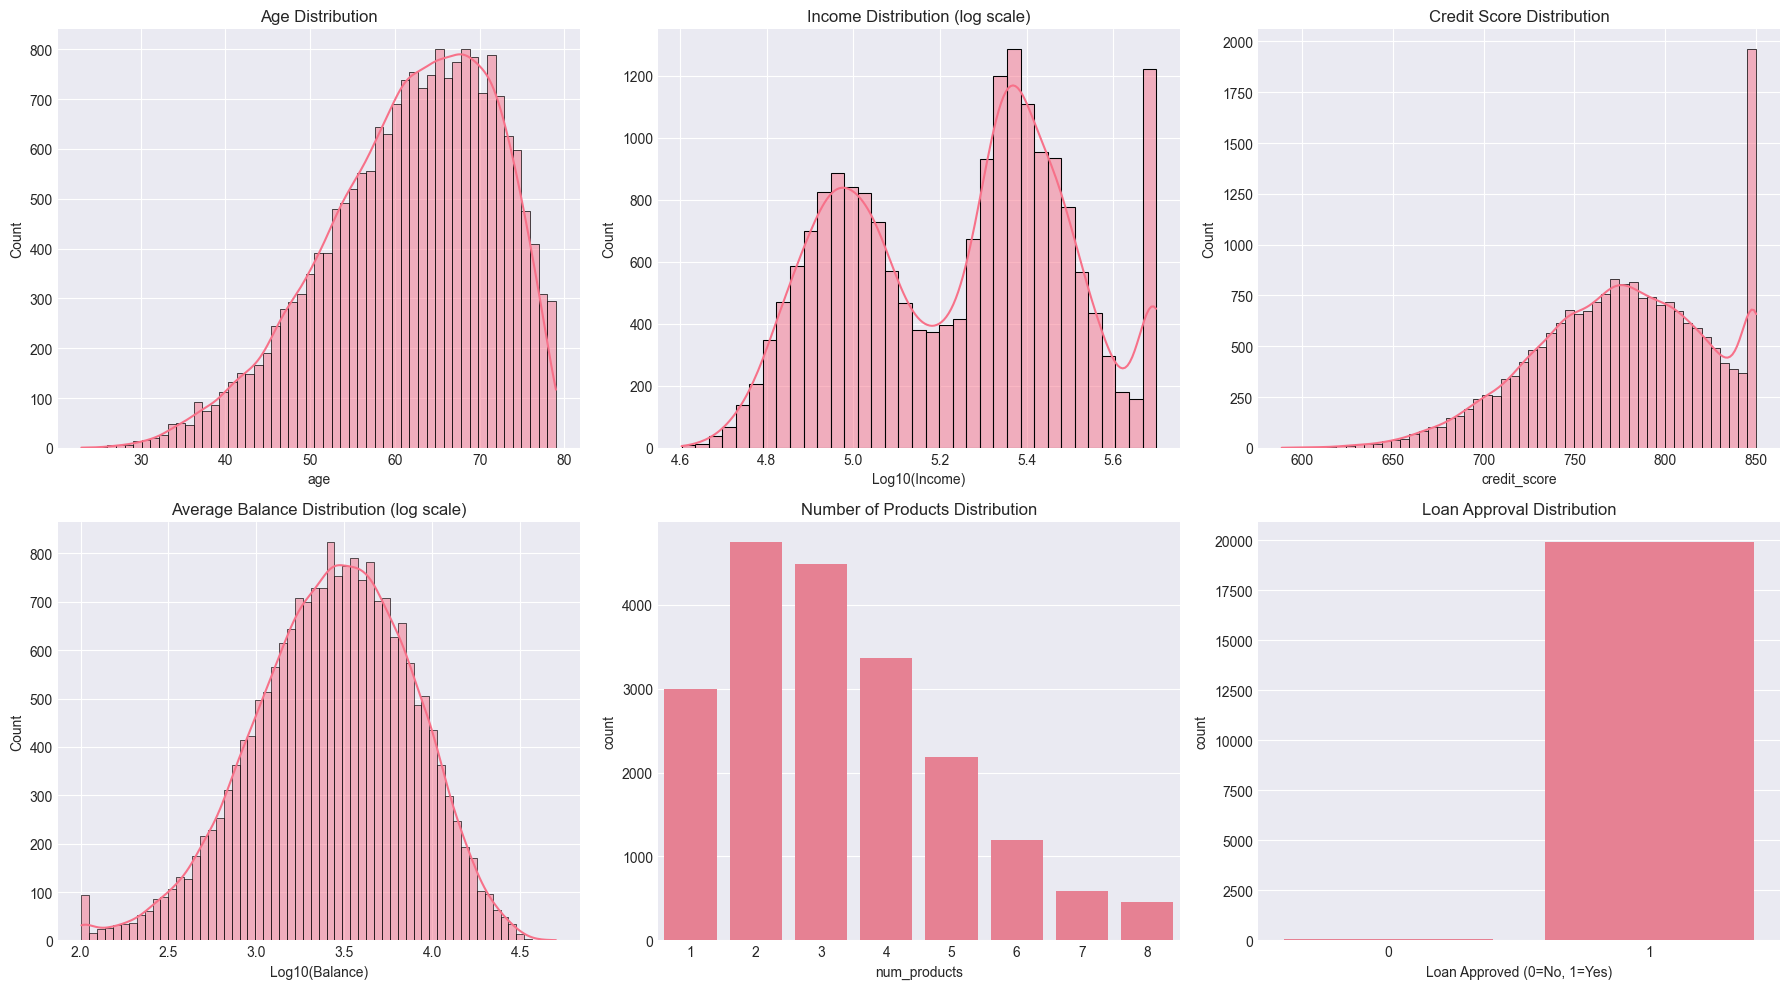

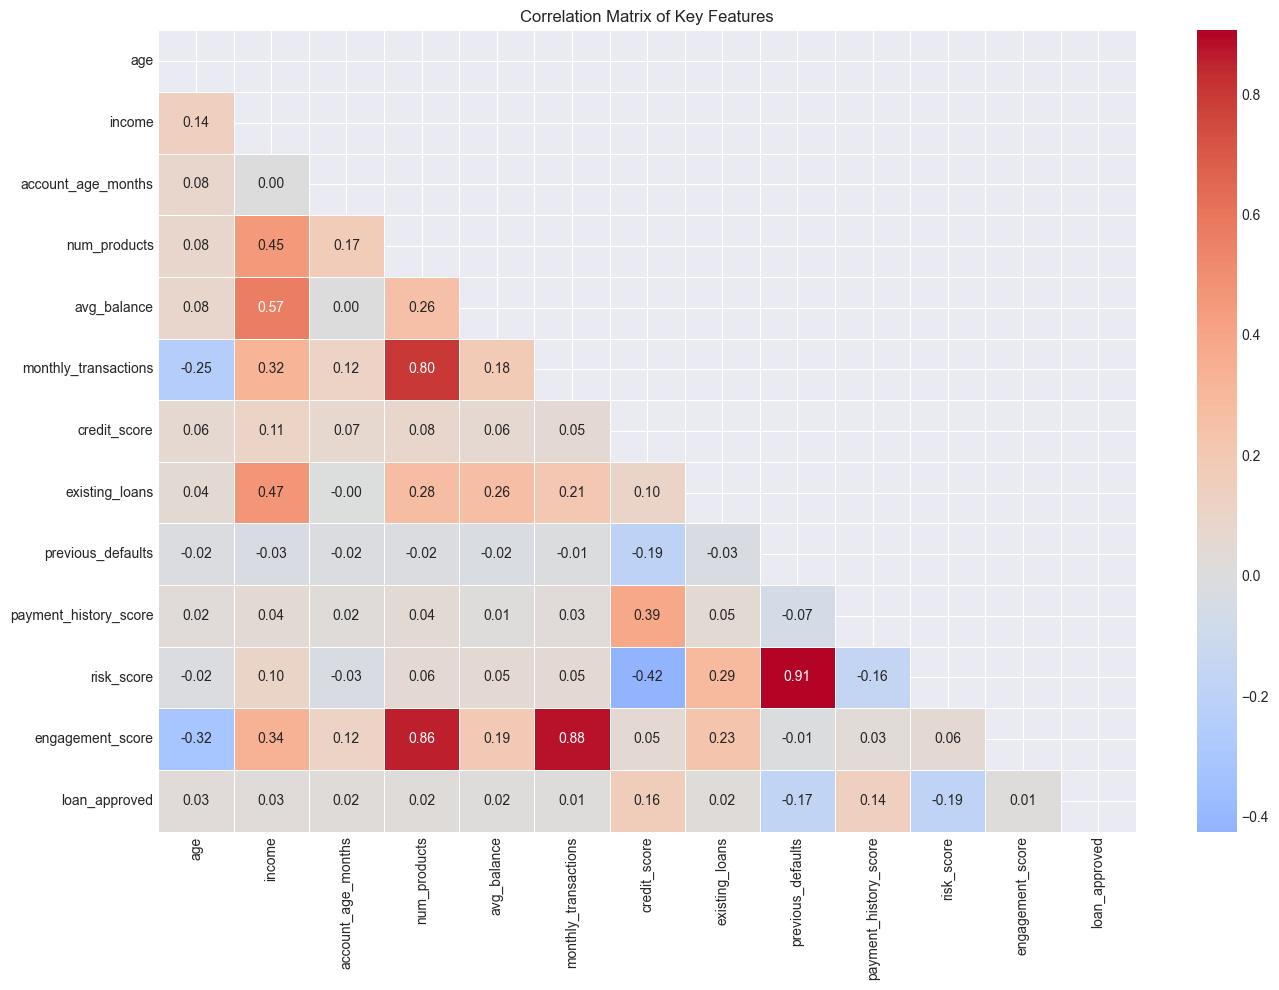

In [9]:

# %% [markdown]
# ## 3. Data Exploration

# %%
# Visualize distributions of key features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Age distribution
sns.histplot(df['age'], kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')

# Income distribution (log scale)
sns.histplot(np.log10(df['income']), kde=True, ax=axes[1])
axes[1].set_title('Income Distribution (log scale)')
axes[1].set_xlabel('Log10(Income)')

# Credit score distribution
sns.histplot(df['credit_score'], kde=True, ax=axes[2])
axes[2].set_title('Credit Score Distribution')

# Average balance (log scale)
sns.histplot(np.log10(df['avg_balance'] + 1), kde=True, ax=axes[3])
axes[3].set_title('Average Balance Distribution (log scale)')
axes[3].set_xlabel('Log10(Balance)')

# Number of products
sns.countplot(x='num_products', data=df, ax=axes[4])
axes[4].set_title('Number of Products Distribution')

# Loan approval distribution
sns.countplot(x='loan_approved', data=df, ax=axes[5])
axes[5].set_title('Loan Approval Distribution')
axes[5].set_xlabel('Loan Approved (0=No, 1=Yes)')

plt.tight_layout()
plt.show()

# %%
# Correlation matrix for numerical features
numerical_features = ['age', 'income', 'account_age_months', 'num_products', 'avg_balance', 
                     'monthly_transactions', 'credit_score', 'existing_loans', 'previous_defaults',
                     'payment_history_score', 'risk_score', 'engagement_score', 'loan_approved']

correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(14, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', 
           cmap='coolwarm', center=0, linewidths=0.5)
plt.title('Correlation Matrix of Key Features')
plt.tight_layout()
plt.show()

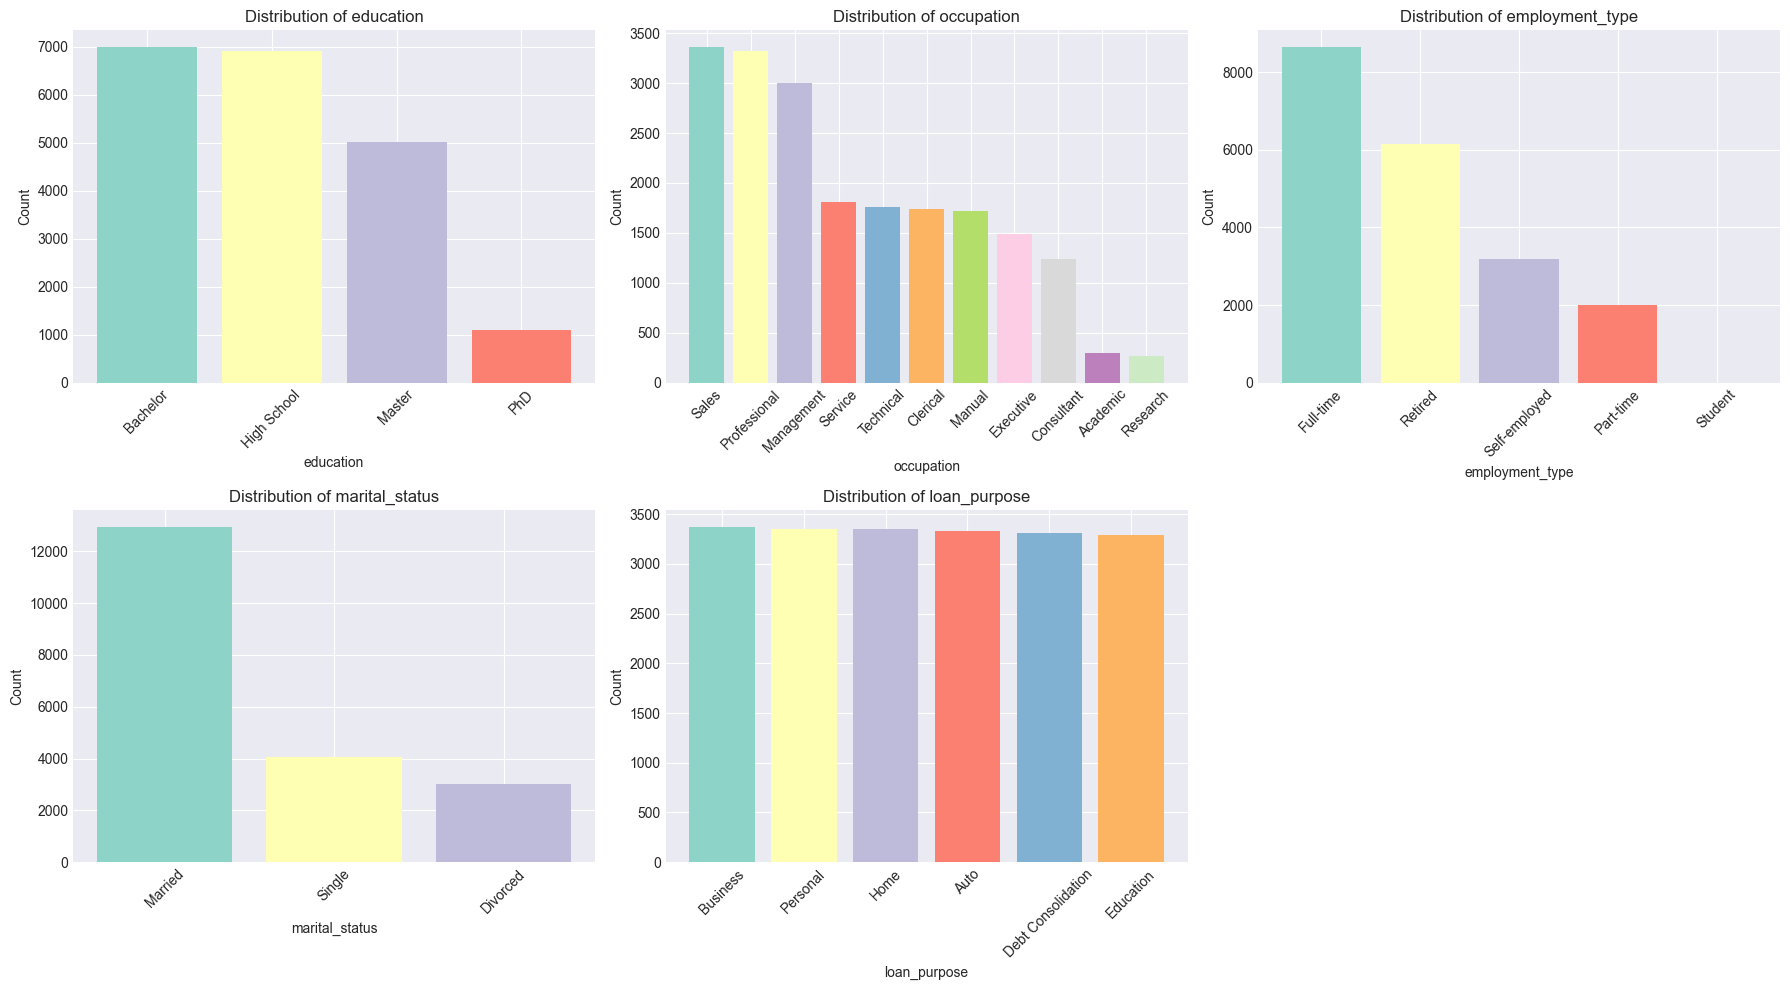

In [10]:
# %%
# Categorical variable distributions
categorical_cols = ['education', 'occupation', 'employment_type', 'marital_status', 'loan_purpose']

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    value_counts = df[col].value_counts()
    axes[idx].bar(value_counts.index, value_counts.values, color=plt.cm.Set3(range(len(value_counts))))
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].tick_params(axis='x', rotation=45)

# Remove extra subplot
axes[-1].set_visible(False)

plt.tight_layout()
plt.show()

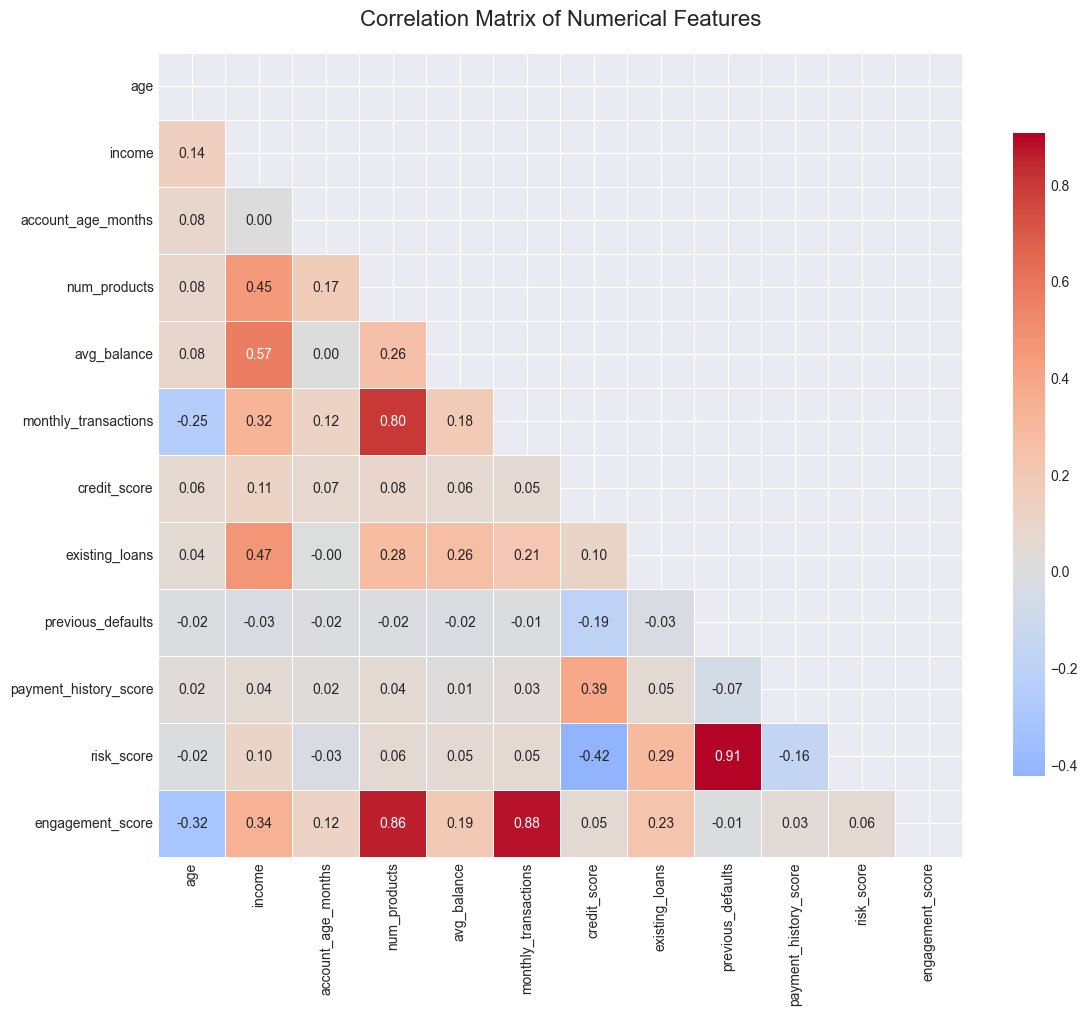

In [11]:
# %%
# Correlation analysis
# Select numerical features for correlation
numerical_features = ['age', 'income', 'account_age_months', 'num_products', 'avg_balance',
                     'monthly_transactions', 'credit_score', 'existing_loans', 'previous_defaults',
                     'payment_history_score', 'risk_score', 'engagement_score']
# Calculate correlation matrix
correlation_matrix = df[numerical_features].corr()

# Create a mask for the upper triangle
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create heatmap
sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f',
            cmap='coolwarm', center=0, square=True, linewidths=0.5,
            cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16, pad=20)
plt.tight_layout()
plt.show()

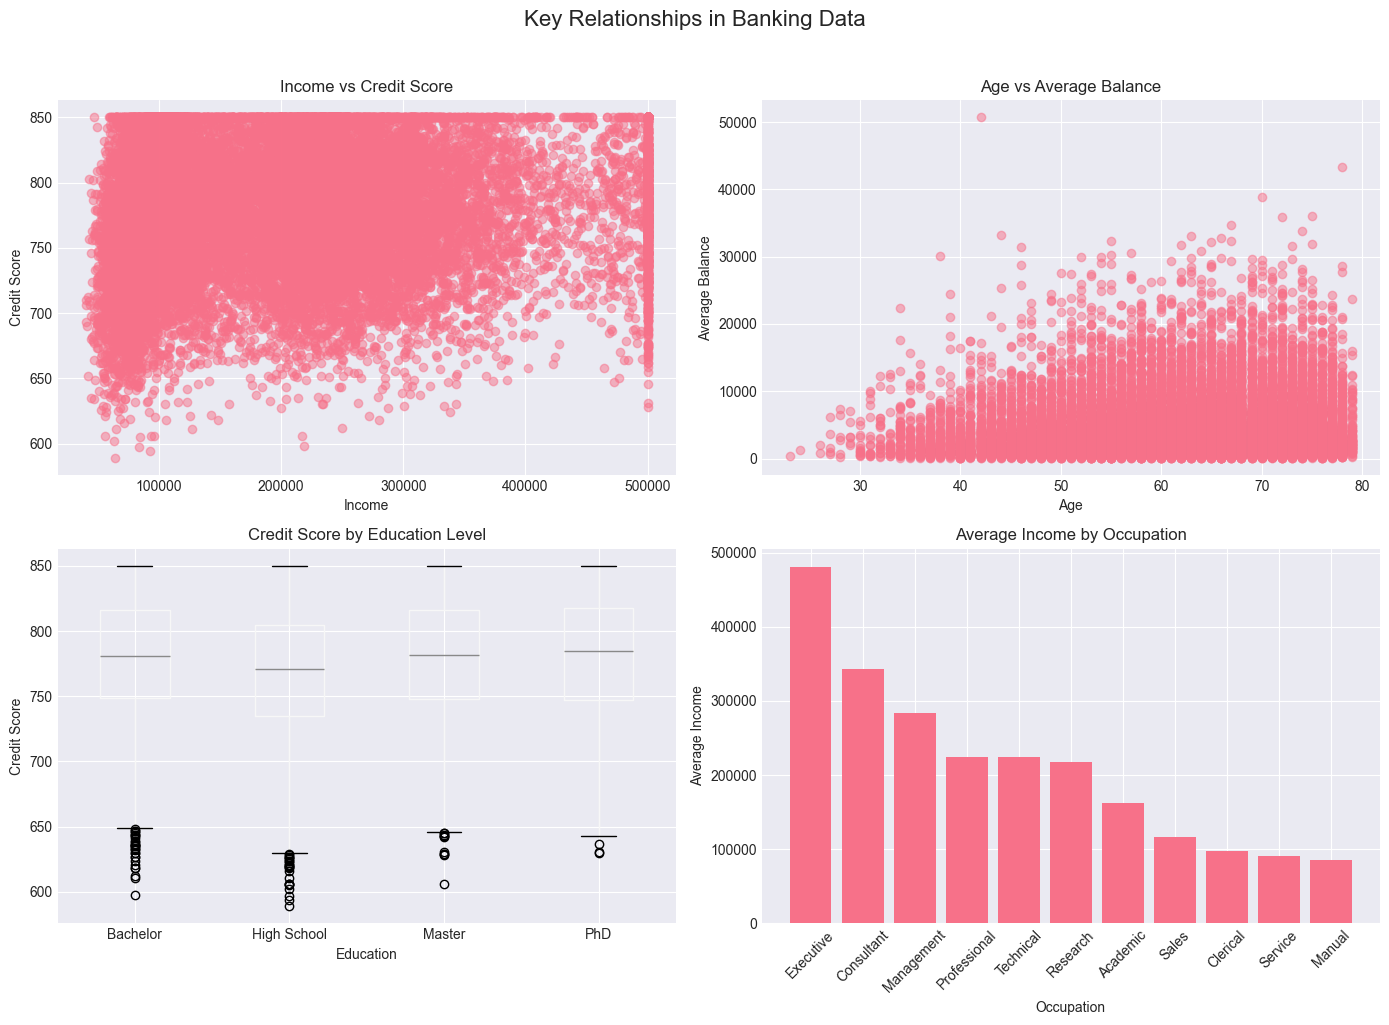

In [12]:
# %%
# Analyze relationships between key variables
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Income vs Credit Score
axes[0, 0].scatter(df['income'], df['credit_score'], alpha=0.5)
axes[0, 0].set_xlabel('Income')
axes[0, 0].set_ylabel('Credit Score')
axes[0, 0].set_title('Income vs Credit Score')

# Age vs Account Balance
axes[0, 1].scatter(df['age'], df['avg_balance'], alpha=0.5)
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Average Balance')
axes[0, 1].set_title('Age vs Average Balance')

# Credit Score by Education
df.boxplot(column='credit_score', by='education', ax=axes[1, 0])
axes[1, 0].set_title('Credit Score by Education Level')
axes[1, 0].set_xlabel('Education')
axes[1, 0].set_ylabel('Credit Score')

# Income by Occupation
occupation_income = df.groupby('occupation')['income'].mean().sort_values(ascending=False)
axes[1, 1].bar(occupation_income.index, occupation_income.values)
axes[1, 1].set_xlabel('Occupation')
axes[1, 1].set_ylabel('Average Income')
axes[1, 1].set_title('Average Income by Occupation')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.suptitle('Key Relationships in Banking Data', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [13]:
# %% [markdown]
# ## 4. Data Preprocessing

# %%
# Initialize the data preprocessor
preprocessor = DataPreprocessor()

# Preprocess the data
print("Preprocessing data...")
X_processed = preprocessor.fit_transform(df)
# If feature names are needed, try to get them from the preprocessor
feature_names = [col for col in df.columns if col != 'loan_approved']
print(f"Number of features: {len(feature_names)}")
print(f"Processed data shape: {X_processed.shape}")



03:25:07 - INFO - DataPreprocessor initialized
Preprocessing data...
03:25:07 - INFO - Fitting preprocessor on data with shape (20000, 27)
03:25:07 - INFO - Creating preprocessing pipeline
03:25:07 - INFO - Pipeline created with 19 numeric and 5 categorical features
03:25:07 - INFO - Total features after preprocessing: 43
03:25:07 - INFO - Data transformed to shape (20000, 43)
Number of features: 26
Processed data shape: (20000, 43)


03:25:07 - INFO - CustomerSegmentation initialized with kmeans algorithm
Finding optimal number of clusters for segmentation...
03:25:07 - INFO - Finding optimal clusters in range (2, 10)
03:25:07 - INFO - Evaluating k=2
03:25:14 - INFO - Evaluating k=3
03:25:20 - INFO - Evaluating k=4
03:25:26 - INFO - Evaluating k=5
03:25:32 - INFO - Evaluating k=6
03:25:37 - INFO - Evaluating k=7
03:25:43 - INFO - Evaluating k=8
03:25:48 - INFO - Evaluating k=9
03:25:54 - INFO - Evaluating k=10
03:26:01 - INFO - Optimal clusters determined: 3
Optimal number of clusters found: {'n_clusters': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'inertia': [293014.90772425826, 258197.9550343941, 227249.7651199217, 213118.17369769898, 204303.68077366636, 196944.31590767956, 190755.65527205268, 186036.25585518393, 182521.25977647328], 'silhouette': [0.2777252845419834, 0.28213721813339837, 0.1646611075948591, 0.16108267625574169, 0.1447834254930821, 0.10462031587380229, 0.10084784494458336, 0.10119517493645458, 0.0979287845496

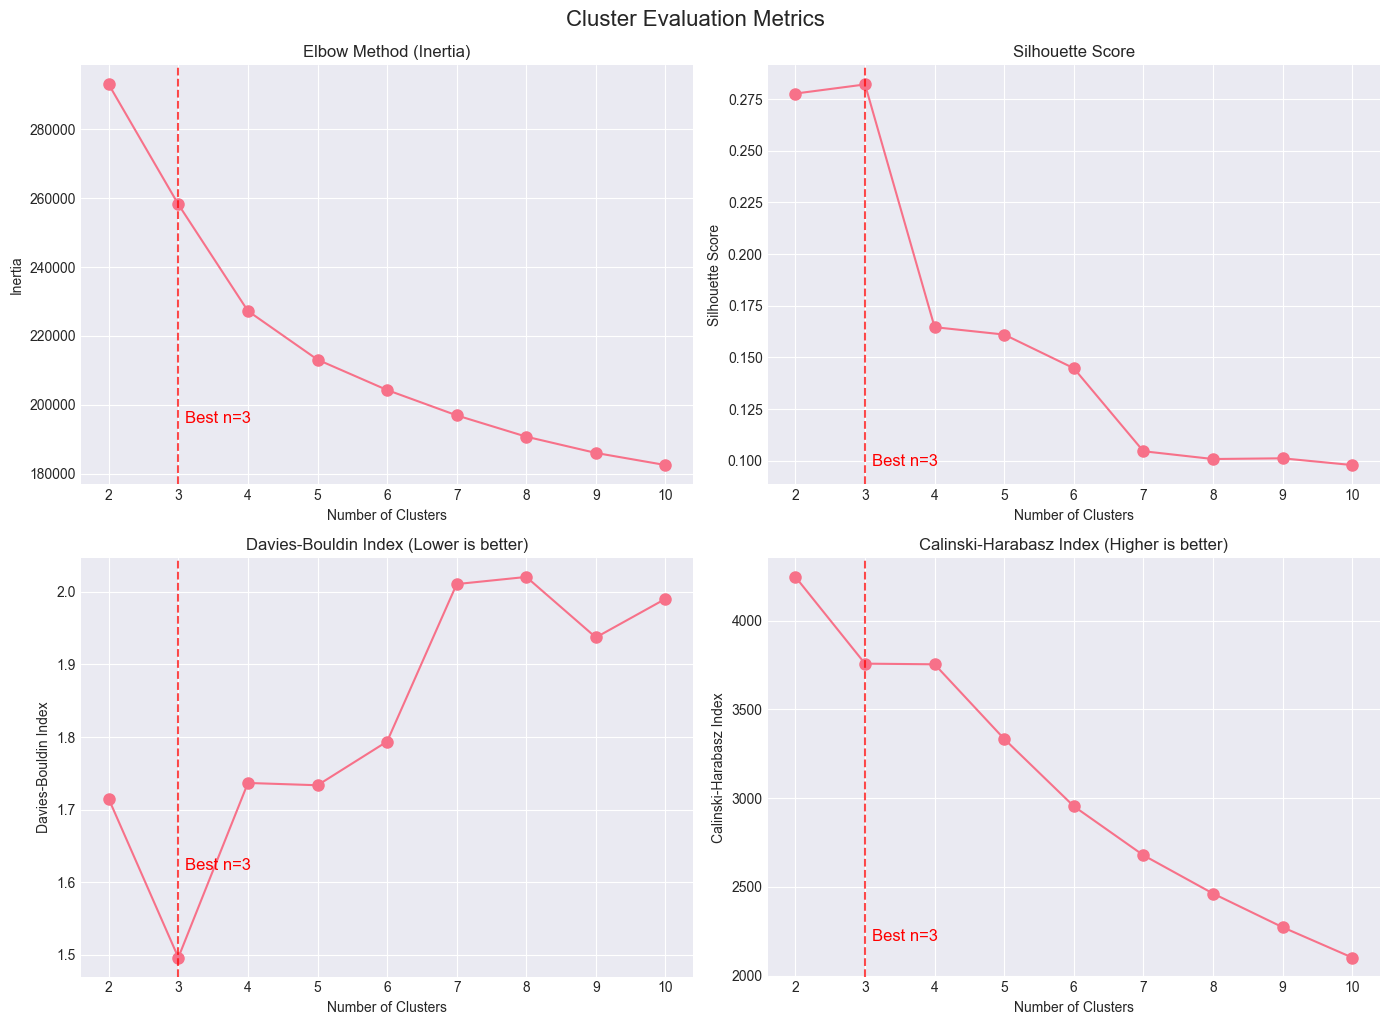

In [14]:
# ## 5. Customer Segmentation

#
# Initialize the customer segmentation model
segmenter = CustomerSegmentation(algorithm='kmeans')

# Define features to use for segmentation
segmentation_features = feature_names.copy()

# Remove the target variable from segmentation features if present
if 'loan_approved' in segmentation_features:
	segmentation_features.remove('loan_approved')

# Find the optimal number of clusters before fitting
print("Finding optimal number of clusters for segmentation...")
optimal_clusters = segmenter.find_optimal_clusters(X_processed)
print(f"Optimal number of clusters found: {optimal_clusters}")

# Visualize the clustering evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot Elbow curve (inertia)
axes[0, 0].plot(optimal_clusters['n_clusters'], optimal_clusters['inertia'], 'o-', markersize=8)
axes[0, 0].set_title('Elbow Method (Inertia)')
axes[0, 0].set_xlabel('Number of Clusters')
axes[0, 0].set_ylabel('Inertia')
axes[0, 0].grid(True)

# Plot Silhouette score
axes[0, 1].plot(optimal_clusters['n_clusters'], optimal_clusters['silhouette'], 'o-', markersize=8)
axes[0, 1].set_title('Silhouette Score')
axes[0, 1].set_xlabel('Number of Clusters')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].grid(True)

# Plot Davies-Bouldin index
axes[1, 0].plot(optimal_clusters['n_clusters'], optimal_clusters['davies_bouldin'], 'o-', markersize=8)
axes[1, 0].set_title('Davies-Bouldin Index (Lower is better)')
axes[1, 0].set_xlabel('Number of Clusters')
axes[1, 0].set_ylabel('Davies-Bouldin Index')
axes[1, 0].grid(True)

# Plot Calinski-Harabasz index
axes[1, 1].plot(optimal_clusters['n_clusters'], optimal_clusters['calinski_harabasz'], 'o-', markersize=8)
axes[1, 1].set_title('Calinski-Harabasz Index (Higher is better)')
axes[1, 1].set_xlabel('Number of Clusters')
axes[1, 1].set_ylabel('Calinski-Harabasz Index')
axes[1, 1].grid(True)

# Highlight the optimal number of clusters
best_n = optimal_clusters['n_clusters'][np.argmax(optimal_clusters['silhouette'])]
for ax in axes.flatten():
    ax.axvline(x=best_n, color='red', linestyle='--', alpha=0.7)
    ax.text(best_n + 0.1, ax.get_ylim()[0] * 1.1, f'Best n={best_n}', 
            color='red', fontsize=12)

plt.tight_layout()
plt.suptitle('Cluster Evaluation Metrics', fontsize=16, y=1.02)
plt.show()

Training segmentation model...
03:26:02 - INFO - Fitting kmeans with 3 clusters
03:26:07 - INFO - Clustering complete. Silhouette score: 0.282
Segmentation complete. Number of segments: 3
Segmentation evaluation metrics:
- Silhouette Score: 0.2821
- Davies-Bouldin Index: 1.4963
- Calinski-Harabasz Index: 3757.1917


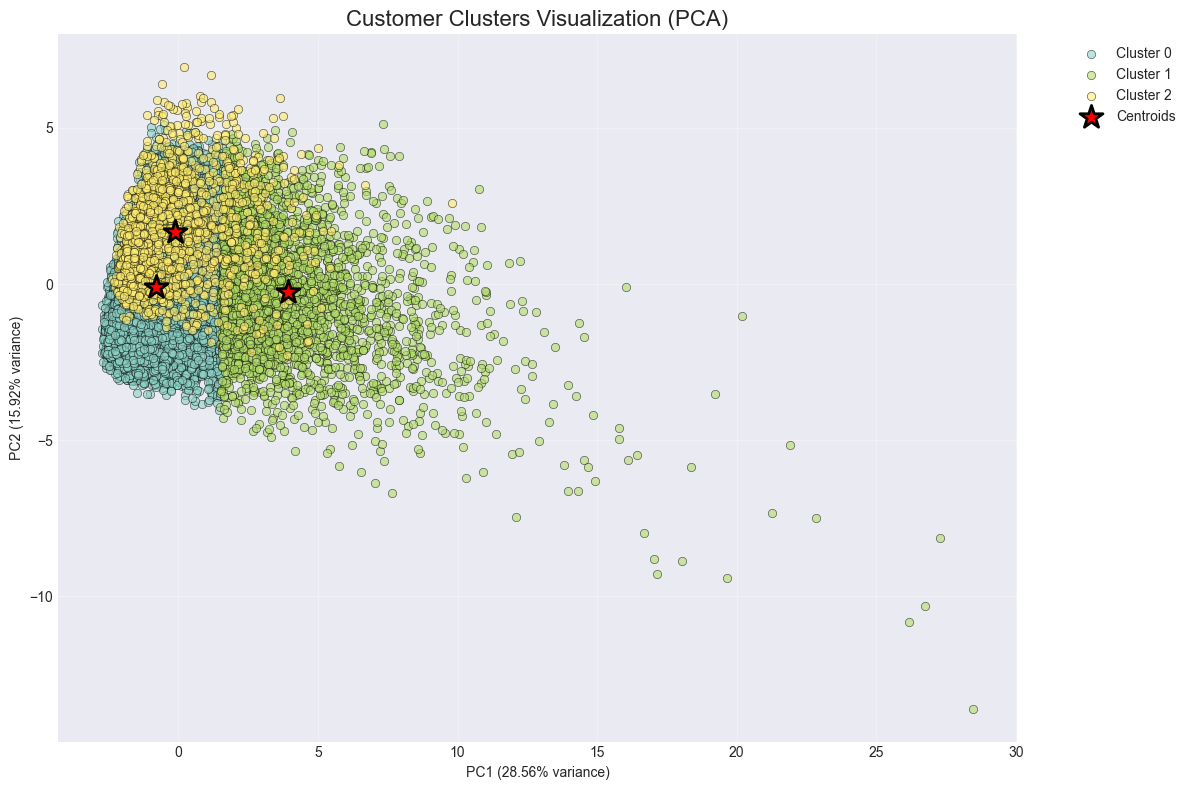

Segment profiles (mean values by segment):


,age,income,dependents,account_age_months,num_products,avg_balance,max_balance,monthly_transactions,avg_transaction_amount,max_transaction_amount,...,credit_score,existing_loans,previous_defaults,payment_history_score,loan_amount_requested,loan_term_months,total_relationship_value,risk_score,engagement_score,loan_approved
segment,,,,,,,,,,,,,,,,,,,,,
0,61.237537,181841.323551,1.144972,48.252276,3.166787,2822.249198,5875.350016,27.272977,132.086407,380.871995,...,777.967049,2.567245,0.000000,0.917727,497858.794432,47.790108,3467.739033,20.039522,43.608082,0.998624
1,64.093905,326885.478234,1.206157,47.850124,3.752488,11689.253731,24857.139303,28.222326,609.000622,2000.532027,...,782.635883,3.154851,0.015236,0.917032,932205.160137,48.089552,4151.603358,23.272481,45.686750,0.998756
2,60.967084,187244.831468,1.146807,46.138907,3.156024,3553.355497,7402.655036,27.109282,174.094799,502.313364,...,744.140882,2.534562,1.031600,0.896231,510797.390388,47.304806,3462.650079,74.838710,43.653511,0.956550


In [15]:


# Set the optimal number of clusters and train the segmentation model
# Use the best_n value determined earlier as the number of clusters
segmenter.n_clusters = best_n
print("Training segmentation model...")
segmenter.fit(X_processed)
segment_indices = segmenter.predict(X_processed)
print(f"Segmentation complete. Number of segments: {segmenter.n_clusters}")

# Add segment labels to the dataframe
df['segment'] = segment_indices

# %%
# Evaluate segmentation quality using scikit-learn metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

print("Segmentation evaluation metrics:")
silhouette = silhouette_score(X_processed, segment_indices)
davies_bouldin = davies_bouldin_score(X_processed, segment_indices)
calinski_harabasz = calinski_harabasz_score(X_processed, segment_indices)

print(f"- Silhouette Score: {silhouette:.4f}")
print(f"- Davies-Bouldin Index: {davies_bouldin:.4f}")
print(f"- Calinski-Harabasz Index: {calinski_harabasz:.4f}")

# %%
# Visualize segments using PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

""" plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=segment_indices, cmap='tab10', alpha=0.6)
plt.title('Customer Segments (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(scatter, label='Segment')
plt.tight_layout()
plt.show() """


plt.figure(figsize=(12, 8))

# Plot each cluster with better visualization
colors = plt.cm.Set3(np.linspace(0, 1, segmenter.n_clusters))
for i in range(segmenter.n_clusters):
    mask = segment_indices == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
               c=[colors[i]], label=f'Cluster {i}',
               alpha=0.6, edgecolors='black', linewidth=0.5)

# Plot centroids if the segmenter has cluster_centers_ attribute
if hasattr(segmenter.model, 'cluster_centers_'):
    centroids_pca = pca.transform(segmenter.model.cluster_centers_)
    plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
               marker='*', s=300, c='red', edgecolor='black', linewidth=2,
               label='Centroids')

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Customer Clusters Visualization (PCA)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# %%
# Analyze segments using pandas groupby
print("Segment profiles (mean values by segment):")
segment_profiles = df.groupby('segment').mean(numeric_only=True)
display(segment_profiles)

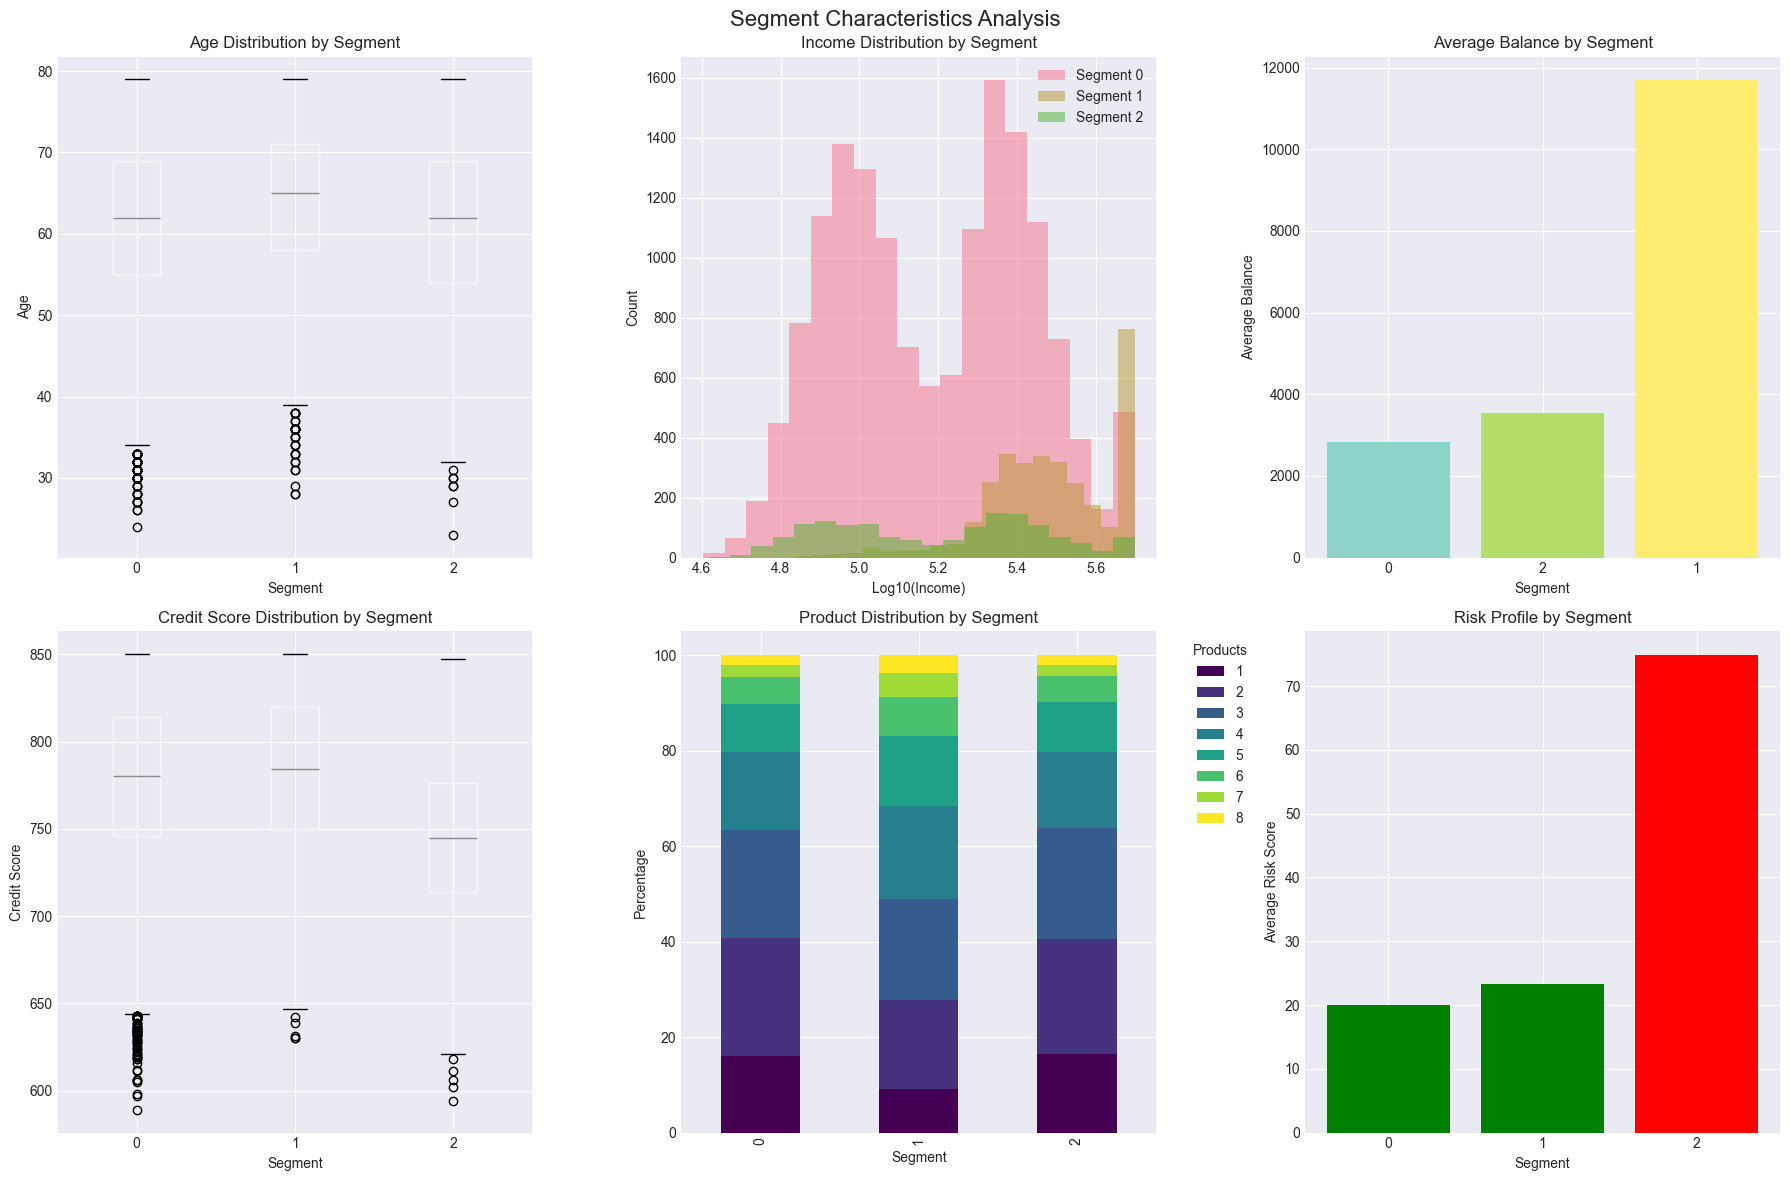

In [16]:

# %%
# Visualize segment characteristics
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

# Plot 1: Age distribution by segment
df.boxplot(column='age', by='segment', ax=axes[0])
axes[0].set_title('Age Distribution by Segment')
axes[0].set_xlabel('Segment')
axes[0].set_ylabel('Age')

# Plot 2: Income distribution by segment (log scale)
for segment in sorted(df['segment'].unique()):
    segment_data = df[df['segment'] == segment]
    axes[1].hist(np.log10(segment_data['income']), alpha=0.5, label=f'Segment {segment}', bins=20)
axes[1].set_xlabel('Log10(Income)')
axes[1].set_ylabel('Count')
axes[1].set_title('Income Distribution by Segment')
axes[1].legend()

# Plot 3: Average balance by segment
segment_avg_balance = df.groupby('segment')['avg_balance'].mean().sort_values()
axes[2].bar(segment_avg_balance.index.astype(str), segment_avg_balance.values,
            color=colors[:len(segment_avg_balance)])
axes[2].set_xlabel('Segment')
axes[2].set_ylabel('Average Balance')
axes[2].set_title('Average Balance by Segment')

# Plot 4: Credit score by segment
df.boxplot(column='credit_score', by='segment', ax=axes[3])
axes[3].set_title('Credit Score Distribution by Segment')
axes[3].set_xlabel('Segment')
axes[3].set_ylabel('Credit Score')

# Plot 5: Number of products by segment
product_dist = df.groupby(['segment', 'num_products']).size().unstack(fill_value=0)
product_dist_pct = product_dist.div(product_dist.sum(axis=1), axis=0) * 100
product_dist_pct.plot(kind='bar', stacked=True, ax=axes[4], colormap='viridis')
axes[4].set_xlabel('Segment')
axes[4].set_ylabel('Percentage')
axes[4].set_title('Product Distribution by Segment')
axes[4].legend(title='Products', bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot 6: Risk score by segment
segment_risk = df.groupby('segment')['risk_score'].mean().sort_values()
axes[5].bar(segment_risk.index.astype(str), segment_risk.values,
            color=['green' if x < 30 else 'orange' if x < 50 else 'red' for x in segment_risk.values])
axes[5].set_xlabel('Segment')
axes[5].set_ylabel('Average Risk Score')
axes[5].set_title('Risk Profile by Segment')

plt.suptitle('Segment Characteristics Analysis', fontsize=16)
plt.tight_layout()
plt.show()

Training set shape: (16000, 43)
Test set shape: (4000, 43)
03:26:14 - INFO - LoanEligibilityPredictor initialized with random_forest
Training and comparing prediction models...
03:26:14 - INFO - Training logistic_regression model
03:26:15 - INFO - logistic_regression - AUC-ROC: 0.992
03:26:15 - INFO - Training random_forest model
03:26:24 - INFO - random_forest - AUC-ROC: 0.999
03:26:24 - INFO - Training xgboost model
03:26:25 - INFO - xgboost - AUC-ROC: 1.000
03:26:25 - INFO - Best model: xgboost
Model comparison results:


,model,accuracy,precision,recall,f1_score,auc_roc
0,logistic_regression,0.99675,0.997242,0.999497,0.998368,0.992161
1,random_forest,0.99850,0.998494,1.000000,0.999247,0.999270
2,xgboost,0.99950,0.999749,0.999749,0.999749,0.999892


Best model: xgboost
Training xgboost model...
03:26:25 - INFO - Training xgboost model
03:26:26 - INFO - xgboost - AUC-ROC: 1.000


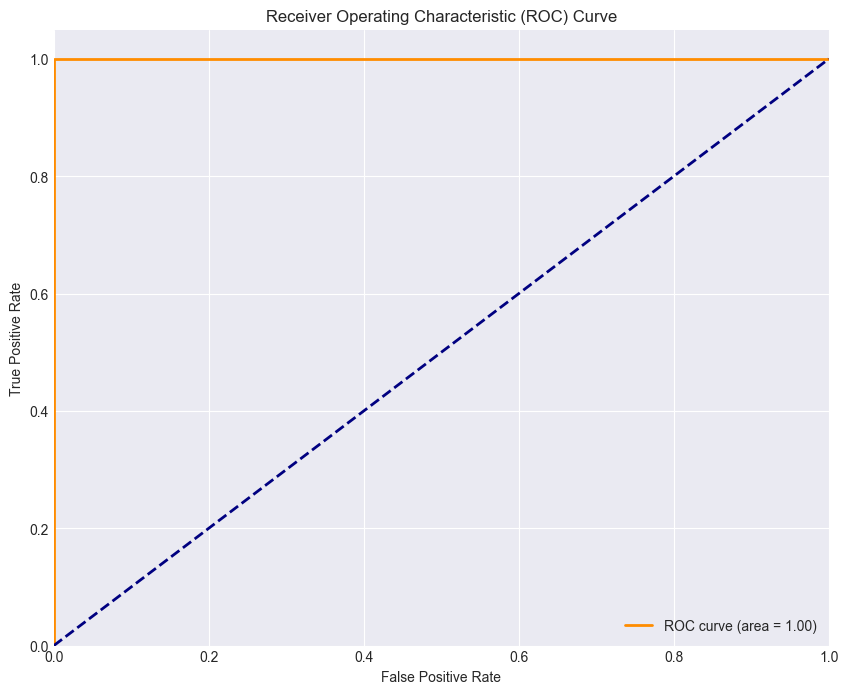

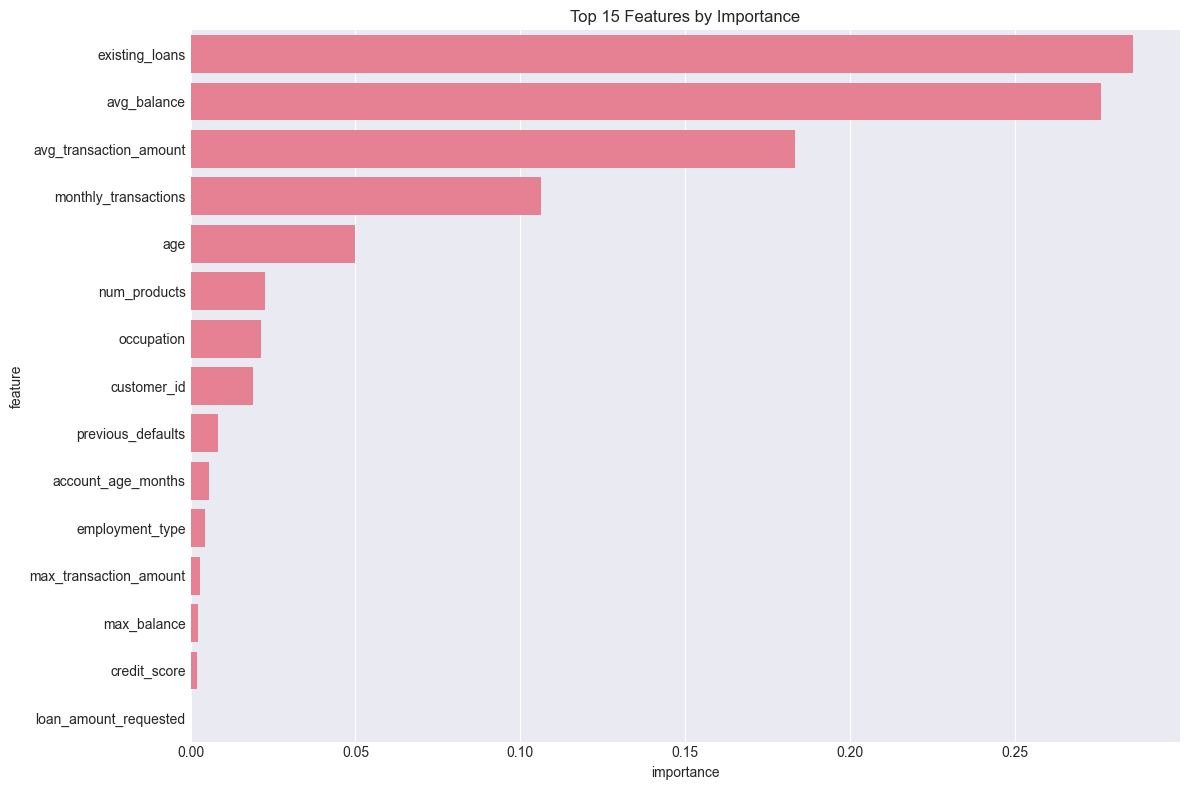

In [17]:

# %% [markdown]
# ## 6. Loan Eligibility Prediction

# %%
# Prepare data for prediction
target_column = 'loan_approved'
y = df[target_column]
X = X_processed

# Split data into training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# %%
# Initialize the loan predictor
predictor = LoanEligibilityPredictor()

# Train multiple models and compare
print("Training and comparing prediction models...")
model_comparison = predictor.train_multiple_models(
    X_train, y_train, X_test, y_test
)

print("Model comparison results:")
display(model_comparison)

# %%
# Train the best model
best_model_type = model_comparison.iloc[model_comparison['auc_roc'].idxmax()]['model']
print(f"Best model: {best_model_type}")

print(f"Training {best_model_type} model...")
predictor.train_single_model(X_train, y_train, X_test, y_test, best_model_type)

# Evaluate on test data
y_pred = predictor.predict(X_test)
y_prob = predictor.predict_proba(X_test)

# %%
# Plot ROC curve
from sklearn.metrics import roc_curve, auc
# Use the probability for the positive class (column 1)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# %%
# Feature importance
try:
    # For random forest and tree-based models
    if hasattr(predictor.model, 'feature_importances_'):
        importances = predictor.model.feature_importances_
    # For linear models
    elif hasattr(predictor.model, 'coef_'):
        importances = np.abs(predictor.model.coef_[0])
    # Try using the predictor's method
    else:
        feature_importance = predictor.get_feature_importance()
        
        # Handle different possible return types
        if isinstance(feature_importance, dict) and 'importance' in feature_importance:
            importances = feature_importance['importance']
        elif isinstance(feature_importance, (np.ndarray, list, pd.Series)):
            importances = feature_importance
        elif hasattr(feature_importance, 'values'):
            importances = feature_importance.values
        else:
            raise ValueError("Unknown feature importance format returned by predictor.")
    
    # Use the transformed feature names if available
    if hasattr(predictor, 'feature_names_'):
        correct_feature_names = predictor.feature_names_
    elif hasattr(X_train, 'columns'):
        correct_feature_names = X_train.columns.tolist()
    else:
        # Fallback to using feature_names from the notebook
        correct_feature_names = feature_names
    
    # Ensure the lengths match
    if len(correct_feature_names) != len(importances):
        min_len = min(len(correct_feature_names), len(importances))
        print(f"Warning: Feature names and importances length mismatch. Trimming to {min_len}.")
        correct_feature_names = correct_feature_names[:min_len]
        importances = importances[:min_len]
except Exception as e:
    print(f"Error extracting feature importance: {e}")
    # Create dummy data as fallback
    importances = np.ones(len(feature_names))
    correct_feature_names = feature_names
    print("Using placeholder feature importance for visualization.")

feature_importance_df = pd.DataFrame({
    'feature': correct_feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df.head(15))
plt.title('Top 15 Features by Importance')
plt.tight_layout()
plt.show()

03:26:26 - INFO - Evaluating model performance by segment
Prediction performance by segment:


,segment,n_samples,accuracy,precision,recall,f1_score,auc_roc
0,0,3077,1.000000,1.000000,1.000000,1.000000,1.000000
1,1,642,1.000000,1.000000,1.000000,1.000000,0.000000
2,2,281,0.992883,0.996241,0.996241,0.996241,0.998997


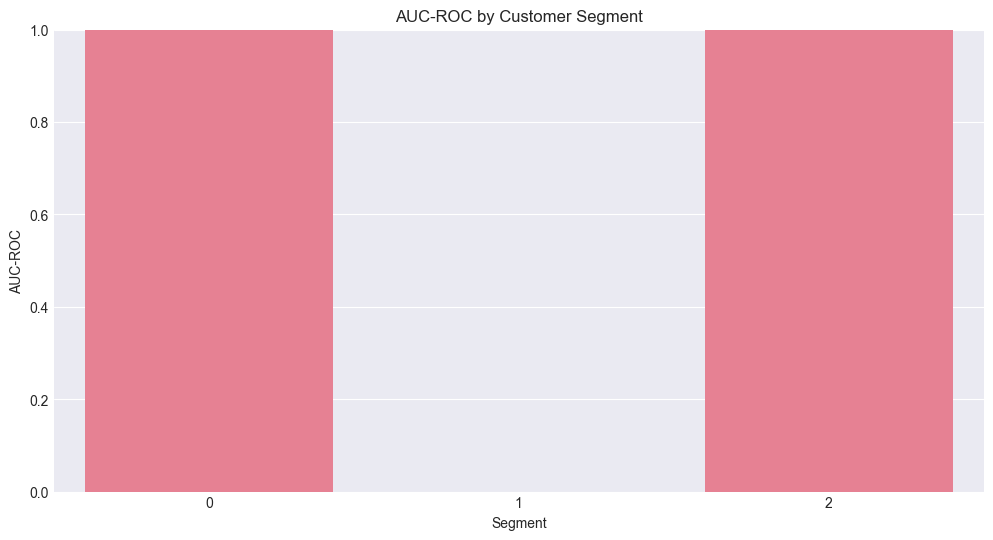

In [18]:
# %% [markdown]
# ## 7. Evaluate Prediction by Segment

# %%
# Evaluate prediction performance by segment
segment_performance = predictor.evaluate_by_segment(X_test, y_test, df.loc[y_test.index, 'segment'].values)
print("Prediction performance by segment:")
display(segment_performance)

# Visualize performance by segment
plt.figure(figsize=(12, 6))
sns.barplot(x='segment', y='auc_roc', data=segment_performance)
plt.title('AUC-ROC by Customer Segment')
plt.xlabel('Segment')
plt.ylabel('AUC-ROC')
plt.ylim(0, 1)
plt.show()

In [19]:

# %% [markdown]
# ## 8. Integrated Pipeline

# %%
# Initialize the integrated pipeline
pipeline = IntegratedBankingPipeline()

# Run the complete pipeline
print("Running integrated pipeline...")
results = pipeline.run_pipeline(df, target_column='loan_approved')

print("Pipeline results:")
for key, value in results.items():
    print(f"- {key}: {type(value)}")

# %%
# Save the pipeline to disk
pipeline.save_pipeline(directory='../models')
print("Pipeline saved to '../models'")


03:26:26 - INFO - Pipeline loaded from models
03:26:26 - INFO - DataPreprocessor initialized
03:26:26 - INFO - CustomerSegmentation initialized with kmeans algorithm
03:26:26 - INFO - LoanEligibilityPredictor initialized with random_forest
03:26:26 - INFO - IntegratedBankingPipeline initialized
Running integrated pipeline...
03:26:26 - INFO - ==================================================
03:26:26 - INFO - BANKING ML PIPELINE - EXECUTION STARTED
03:26:26 - INFO - ==================================================
03:26:26 - INFO - 
[Step 1] Data Preprocessing
03:26:26 - INFO - Starting feature engineering
03:26:26 - INFO - Feature engineering completed
03:26:26 - INFO - Fitting preprocessor on data with shape (20000, 32)
03:26:26 - INFO - Creating preprocessing pipeline
03:26:26 - INFO - Pipeline created with 19 numeric and 5 categorical features
03:26:27 - INFO - Total features after preprocessing: 43
03:26:27 - INFO - Data transformed to shape (20000, 43)
03:26:27 - INFO - Data p

In [20]:

# %% [markdown]
# ## 9. Make Predictions with the Integrated Pipeline

# %%
# Create a sample customer for prediction
sample_customer = df.iloc[0:1].copy()
print("Sample customer data:")
display(sample_customer)

# Add a predict method to the pipeline instance since it doesn't have one
def predict_method(self, sample_data):
	# Use the existing models to make predictions
	
	# Preprocess the data
	X_sample = preprocessor.transform(sample_data)
	
	# Get the segment
	segment = segmenter.predict(X_sample)[0]
	
	# Predict loan approval
	loan_approved = predictor.predict(X_sample)[0]
	approval_proba = predictor.predict_proba(X_sample)[0, 1]
	
	# Create a recommendation
	if loan_approved:
		recommendation = f"Loan approved with {approval_proba:.2f} confidence. Customer belongs to segment {segment}."
	else:
		recommendation = f"Loan denied. Customer belongs to segment {segment}."
	
	return {
		'approval_probability': approval_proba,
		'loan_approved': bool(loan_approved),
		'customer_segment': segment,
		'recommendation': recommendation
	}

# Add the predict method to the pipeline instance
import types
pipeline.predict = types.MethodType(predict_method, pipeline)

# Make prediction using the pipeline
prediction = pipeline.predict(sample_customer)
print("\nPrediction result:")
print(f"Probability of loan approval: {prediction['approval_probability']:.2f}")
print(f"Loan approved: {'Yes' if prediction['loan_approved'] else 'No'}")
print(f"Customer segment: {prediction['customer_segment']}")
print(f"Recommendation: {prediction['recommendation']}")


Sample customer data:


,customer_id,age,income,education,occupation,employment_type,marital_status,dependents,account_age_months,num_products,...,previous_defaults,payment_history_score,loan_amount_requested,loan_term_months,loan_purpose,total_relationship_value,risk_score,engagement_score,loan_approved,segment
0,CUST000001,61,198256,Bachelor,Professional,Full-time,Divorced,2,180,6,...,0,0.785116,341973,12,Auto,6471.81,20.3,61.474226,1,0



Prediction result:
Probability of loan approval: 1.00
Loan approved: Yes
Customer segment: 0
Recommendation: Loan approved with 1.00 confidence. Customer belongs to segment 0.


In [21]:


# %% [markdown]
# ## 10. Conclusion

# %%
# Print summary statistics
print("Pipeline Training Summary:")
print(f"- Data size: {len(df)} customers")
print(f"- Number of segments: {segmenter.n_clusters}")
print(f"- Best model for loan prediction: {best_model_type}")
print(f"- Test AUC-ROC: {roc_auc:.4f}")
print("\nTop 5 features for loan prediction:")
for _, row in feature_importance_df.head(5).iterrows():
    print(f"- {row['feature']}: {row['importance']:.4f}")

Pipeline Training Summary:
- Data size: 20000 customers
- Number of segments: 3
- Best model for loan prediction: xgboost
- Test AUC-ROC: 0.9999

Top 5 features for loan prediction:
- existing_loans: 0.2857
- avg_balance: 0.2761
- avg_transaction_amount: 0.1832
- monthly_transactions: 0.1061
- age: 0.0497
